<a href="https://colab.research.google.com/github/FrodoBaggins87/Machine_Learning/blob/main/MultiClassClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
!pip install torchmetrics


Make Toy Dataset


tensor([[ 2.5863, -9.3816],
        [-5.9339,  6.1434],
        [ 3.2644,  6.9292],
        [ 4.6469, -7.1285],
        [-7.3449, -5.9539]]) tensor([4, 3, 2, 4, 1])


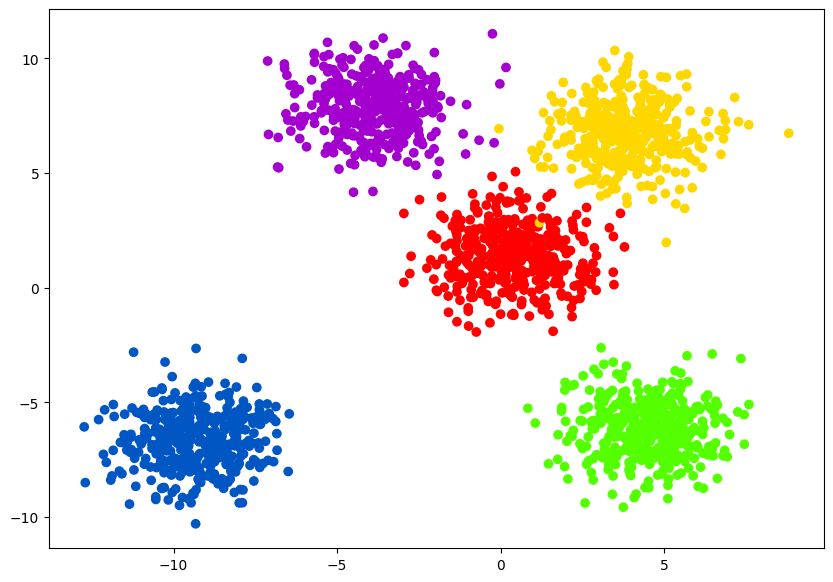

In [89]:
#import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from torchmetrics.classification import MulticlassAccuracy
RANDOM_SEED=101
#make dataset
#x_blob contains coordinates of the point, y_blob contains which blob the point belongs to
x_blob, y_blob= make_blobs(n_samples=2000,#number of points
                           n_features=2,#number of dimensions of the points basically
                           centers=5, #number of blobs
                           cluster_std=1.2, #to add noise in the cluster points
                           random_state=RANDOM_SEED)#random seed
#turning into tensors
x_blob=torch.from_numpy(x_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)#LongTensor makes tensor of dtype int64
print(x_blob[:5],y_blob[:5])

#split into training and test dataset
x_blob_train, x_blob_test, y_blob_train, y_blob_test=train_test_split(x_blob, y_blob, test_size=0.25, random_state=RANDOM_SEED)

#PLOTTING
plt.figure(figsize=(10,7))
plt.scatter(x_blob[:,0],x_blob[:,1],c=y_blob, cmap=plt.cm.prism)


Making Device Agnostic Code

In [90]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Build Model

In [91]:
from torch import nn
class BlobModel_0(nn.Module):
  def __init__(self, input_features, output_features):
    super().__init__()
    self.network=nn.Sequential(
        nn.Linear(in_features=input_features, out_features=5),
        nn.ReLU(),
        nn.Linear(in_features=5, out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=15),
        nn.ReLU(),
        nn.Linear(in_features=15, out_features=output_features)
    )
  def forward(self,x):
    return self.network(x)
#creating and instance of BlobModel and put in device
model_0=BlobModel_0(input_features=2, output_features=5).to(device)#input_features tell number of number of features, out features tell number of classes(number of blobs)
model_0


BlobModel_0(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=15, bias=True)
    (5): ReLU()
    (6): Linear(in_features=15, out_features=5, bias=True)
  )
)

Creating Loss Function and Optimizer

In [92]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model_0.parameters(),
                       lr=0.05)

In [93]:
#looking at logits produced by model
model_0(x_blob_train.to(device))[:5]

tensor([[-0.0553, -0.2123, -0.2683, -0.1110, -0.1376],
        [-0.1427, -0.0715, -0.6978, -0.1081, -0.3816],
        [ 0.0810, -0.3626,  0.0378,  0.0089, -0.4454],
        [-0.0891, -0.0895, -0.6967, -0.1129, -0.4641],
        [-0.1247, -0.1963, -0.0886,  0.1352, -0.1322]],
       grad_fn=<SliceBackward0>)

In [94]:
model_0(x_blob_train.to(device))[0].shape #should be equal to number of blobs/classes in data

torch.Size([5])

Make prediction with model using SoftMax activation function

In [95]:
y_logits=model_0(x_blob_test.to(device))
#using softmax activation function
y_pred_prob=torch.softmax(y_logits,dim=1)#dim chooses which dimension is softmax applied across, read its documentation
print(y_logits[:5])
print(y_pred_prob[:5])


tensor([[-0.0563, -0.0615, -0.7697, -0.1071, -0.5870],
        [-0.0681, -0.2026, -0.2395, -0.0787, -0.1418],
        [ 0.1228, -0.3803,  0.1497,  0.0579, -0.5182],
        [ 0.1951, -0.4444,  0.1463, -0.0153, -0.6161],
        [-0.0516, -0.2133, -0.2462, -0.0950, -0.1440]],
       grad_fn=<SliceBackward0>)
tensor([[0.2486, 0.2473, 0.1218, 0.2362, 0.1462],
        [0.2158, 0.1886, 0.1818, 0.2135, 0.2004],
        [0.2442, 0.1476, 0.2508, 0.2288, 0.1286],
        [0.2678, 0.1413, 0.2550, 0.2170, 0.1190],
        [0.2201, 0.1872, 0.1812, 0.2108, 0.2007]], grad_fn=<SliceBackward0>)


In [96]:
#choosing which class the data point belongs most likely to
#print(y_pred_prob[0])#the sum of the probabilities should be 1.0
y_pred=y_pred_prob.argmax(dim=1)
y_pred, y_blob_test
#defining accuracy function for multi class classification
accuracy=MulticlassAccuracy(num_classes=5)
print(accuracy(y_pred,y_blob_test).item())

0.28656166791915894


Making Training Loop

In [97]:
from torchmetrics import Accuracy
torch.manual_seed(100)
#set number of epochs
epochs=1000
#putting data into target device
x_blob_train, x_blob_test=x_blob_train.to(device), x_blob_test.to(device)
y_blob_train, y_blob_test= y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  #Training
  model_0.train()

  #forwward pass
  y_logits=model_0(x_blob_train)
  #activation function
  y_pred_prob=torch.softmax(y_logits,dim=1)
  #finding most likely blob/class by finding argument of maximum probability
  y_pred=y_pred_prob.argmax(dim=1)#dim=1 contains the probabilities for different blobs/classes

  #calc loss and accuracy
  loss=loss_fn(y_logits,y_blob_train)
  acc=(accuracy(y_pred, y_blob_train).item())*100#in percentage
  # optimizer zer_grad
  optimizer.zero_grad()
  #loss backward
  loss.backward()
  #optimizer step
  optimizer.step()

  #Testing
  model_0.eval()
  with torch.inference_mode():
    #forward pass
    test_logits=model_0(x_blob_test)
    test_pred=torch.softmax(test_logits,dim=1).argmax(dim=1)
    #test loss and accuracy
    test_loss=loss_fn(test_logits, y_blob_test)
    test_accuracy= (accuracy(test_pred, y_blob_test).item())*100# in percentage

    if epoch%50==0:
      print("Training Loss:", loss.item(), "Training accuracy:", acc, "Test Loss:", test_loss.item(), "Test Accuracy:", test_accuracy)

Training Loss: 1.5323249101638794 Training accuracy: 28.586125373840332 Test Loss: 1.4668159484863281 Test Accuracy: 35.380399227142334
Training Loss: 0.7066164612770081 Training accuracy: 79.45778369903564 Test Loss: 0.6921038031578064 Test Accuracy: 79.5461118221283
Training Loss: 0.3306090533733368 Training accuracy: 87.2909665107727 Test Loss: 0.32978561520576477 Test Accuracy: 86.70597672462463
Training Loss: 0.22210213541984558 Training accuracy: 94.31437849998474 Test Loss: 0.22343522310256958 Test Accuracy: 93.8346803188324
Training Loss: 0.16302034258842468 Training accuracy: 97.05685377120972 Test Loss: 0.16791106760501862 Test Accuracy: 97.59705662727356
Training Loss: 0.12089633196592331 Training accuracy: 98.12708497047424 Test Loss: 0.12780295312404633 Test Accuracy: 97.9934811592102
Training Loss: 0.0946403294801712 Training accuracy: 98.99665117263794 Test Loss: 0.10258220136165619 Test Accuracy: 98.19149971008301
Training Loss: 0.07572348415851593 Training accuracy: 99

Plotting Data


In [100]:
#function taken from helper_functions.py source code
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.prism)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


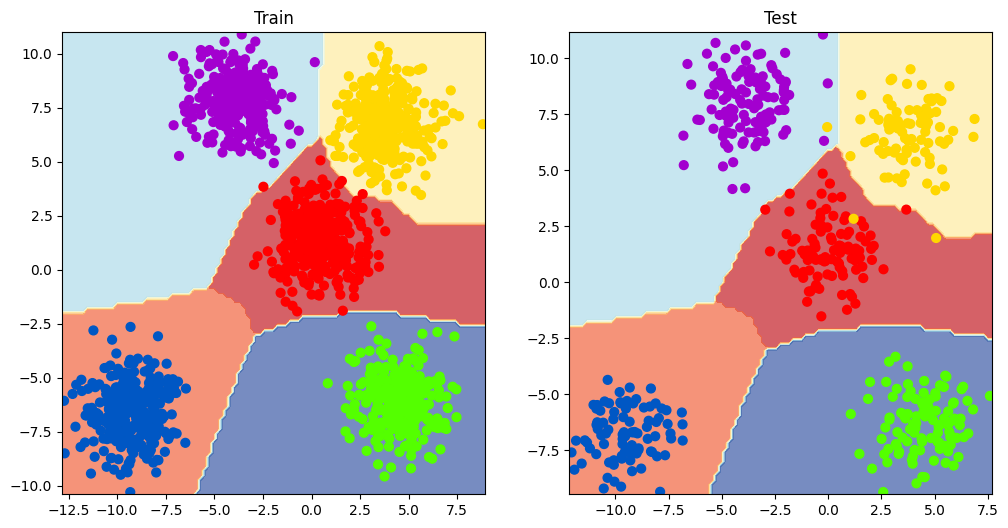

In [101]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, x_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, x_blob_test, y_blob_test)